# Introduction

# Libraries and Modules

In [199]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import pandas_profiling
import itertools

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("dark")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("GnBu_d")

import os, shutil

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, f1_score,precision_recall_fscore_support
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score

In [2]:
import eda
import image_classification as im
%reload_ext autoreload
%autoreload 2

# Data

## Data Fields

* Type - Type of animal (1 = Dog, 2 = Cat)
* Name - Name of pet (Empty if not named)
* Age - Age of pet when listed, in months
* Breed1 - Primary breed of pet (Refer to breed_labels.csv)
* Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to breed_labels.csv
* Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
* Color1 - Color 1 of pet (Refer to color_labels.csv)
* Color2 - Color 2 of pet (Refer to color_labels.csv)
* Color3 - Color 3 of pet (Refer to color_labels.csv)
* MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
* Quantity - Number of pets represented in profile
* Fee - Adoption fee (0 = Free)
* State - State location in Malaysia (Refer to state_labels.csv)
* RescuerID - Unique hash ID of rescuer
* VideoAmt - Total uploaded videos for this pet
* Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.
* PetID - Unique hash ID of pet profile
* PhotoAmt - Total uploaded photos for this pet
* AdoptionSpeed - Categorical speed of adoption:
    - 0 - Pet was adopted on the same day as it was listed.
    - 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
    - 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
    - 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
    - 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

In [3]:
!pwd

/Users/valmadrid/DataScienceBootcamp/Projects/Final Project/Predicting-PetFinder-Adoption-Rate


In [22]:
df = pd.read_csv("dataset/petfinder-adoption-prediction/train/train.csv")
df.columns = df.columns.map(lambda x: x.lower())
df.head(2)

type         name  age  breed1  breed2  gender  color1  color2  color3  \
0     2       Nibble    3     299       0       1       1       7       0   
1     2  No Name Yet    1     265       0       1       1       2       0   

   maturitysize  furlength  vaccinated  dewormed  sterilized  health  \
0             1          1           2         2           2       1   
1             2          2           3         3           3       1   

   quantity  fee  state                         rescuerid  videoamt  \
0         1  100  41326  8480853f516546f6cf33aa88cd76c379         0   
1         1    0  41401  3082c7125d8fb66f7dd4bff4192c8b14         0   

                                         description      petid  photoamt  \
0  Nibble is a 3+ month old ball of cuteness. He ...  86e1089a3       1.0   
1  I just found it alone yesterday near my apartm...  6296e909a       2.0   

   adoptionspeed  
0              2  
1              0

## Data Cleaning and Visualisation

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
type             14993 non-null int64
name             13736 non-null object
age              14993 non-null int64
breed1           14993 non-null int64
breed2           14993 non-null int64
gender           14993 non-null int64
color1           14993 non-null int64
color2           14993 non-null int64
color3           14993 non-null int64
maturitysize     14993 non-null int64
furlength        14993 non-null int64
vaccinated       14993 non-null int64
dewormed         14993 non-null int64
sterilized       14993 non-null int64
health           14993 non-null int64
quantity         14993 non-null int64
fee              14993 non-null int64
state            14993 non-null int64
rescuerid        14993 non-null object
videoamt         14993 non-null int64
description      14981 non-null object
petid            14993 non-null object
photoamt         14993 non-null float64
adoptionspe

In [24]:
breeds = pd.read_csv("dataset/petfinder-adoption-prediction/breed_labels.csv")
colors = pd.read_csv("dataset/petfinder-adoption-prediction/color_labels.csv")
states = pd.read_csv("dataset/petfinder-adoption-prediction/state_labels.csv")

df = eda.get_breed(df, breeds, "breed1")
df = eda.get_breed(df, breeds, "breed2")
df = eda.get_color(df, colors, "color1")
df = eda.get_color(df, colors, "color2")
df = eda.get_color(df, colors, "color3")
df = eda.get_state(df, states, "state")
df.head(2)

type         name  age  breed1  breed2  gender  color1  color2  color3  \
0     2       Nibble    3     299       0       1       1       7       0   
1     2  No Name Yet    1     265       0       1       1       2       0   

   maturitysize  furlength  vaccinated  dewormed  sterilized  health  \
0             1          1           2         2           2       1   
1             2          2           3         3           3       1   

   quantity  fee  state                         rescuerid  videoamt  \
0         1  100  41326  8480853f516546f6cf33aa88cd76c379         0   
1         1    0  41401  3082c7125d8fb66f7dd4bff4192c8b14         0   

                                         description      petid  photoamt  \
0  Nibble is a 3+ month old ball of cuteness. He ...  86e1089a3       1.0   
1  I just found it alone yesterday near my apartm...  6296e909a       2.0   

   adoptionspeed           breed1_desc breed2_desc color1_desc color2_desc  \
0              2                 tabby         NaN       black       white   
1              0  domestic_medium_hair         NaN       black       brown   

  color3_desc    state_desc  
0         NaN      selangor  
1         NaN  kuala_lumpur

In [25]:
#Rearrange the column headers
df = df[[
    "adoptionspeed", "petid", "type", "name", "age", "breed1", "breed1_desc",
    "breed2", "breed2_desc", "gender", "color1", "color1_desc", "color2",
    "color2_desc", "color3", "color3_desc", "maturitysize", "furlength",
    "vaccinated", "dewormed", "sterilized", "health", "quantity", "fee",
    "state", "state_desc", "rescuerid", "videoamt", "photoamt", "description"
]]

#Rename the columns (add "_")
df.rename(mapper={
    "maturitysize": "maturity_size",
    "furlength": "fur_length",
    "rescuerid": "rescuer_id",
    "videoamt": "video_amt",
    "photoamt": "photo_amt",
    "petid": "pet_id",
    "adoptionspeed": "adoption_speed"
},
            axis=1,
            inplace=True)

df.head(2)

adoption_speed     pet_id  type         name  age  breed1  \
0               2  86e1089a3     2       Nibble    3     299   
1               0  6296e909a     2  No Name Yet    1     265   

            breed1_desc  breed2 breed2_desc  gender  color1 color1_desc  \
0                 tabby       0         NaN       1       1       black   
1  domestic_medium_hair       0         NaN       1       1       black   

   color2 color2_desc  color3 color3_desc  maturity_size  fur_length  \
0       7       white       0         NaN              1           1   
1       2       brown       0         NaN              2           2   

   vaccinated  dewormed  sterilized  health  quantity  fee  state  \
0           2         2           2       1         1  100  41326   
1           3         3           3       1         1    0  41401   

     state_desc                        rescuer_id  video_amt  photo_amt  \
0      selangor  8480853f516546f6cf33aa88cd76c379          0        1.0   
1  kuala_lumpur  3082c7125d8fb66f7dd4bff4192c8b14          0        2.0   

                                         description  
0  Nibble is a 3+ month old ball of cuteness. He ...  
1  I just found it alone yesterday near my apartm...

In [26]:
#Save this version
df.to_csv("pets.csv", index=False)

In [9]:
#Run a profile report
petfinder_report = pets.profile_report(
    title="Petfinder.my Detailed Profile Report",
    correlation_threshold_pearson=.9,
    sort="None")
petfinder_report.to_file(output_file="pets.html")
petfinder_report

### Age

In [126]:
pets = pd.read_csv("pets.csv")
pets.shape

(14993, 30)

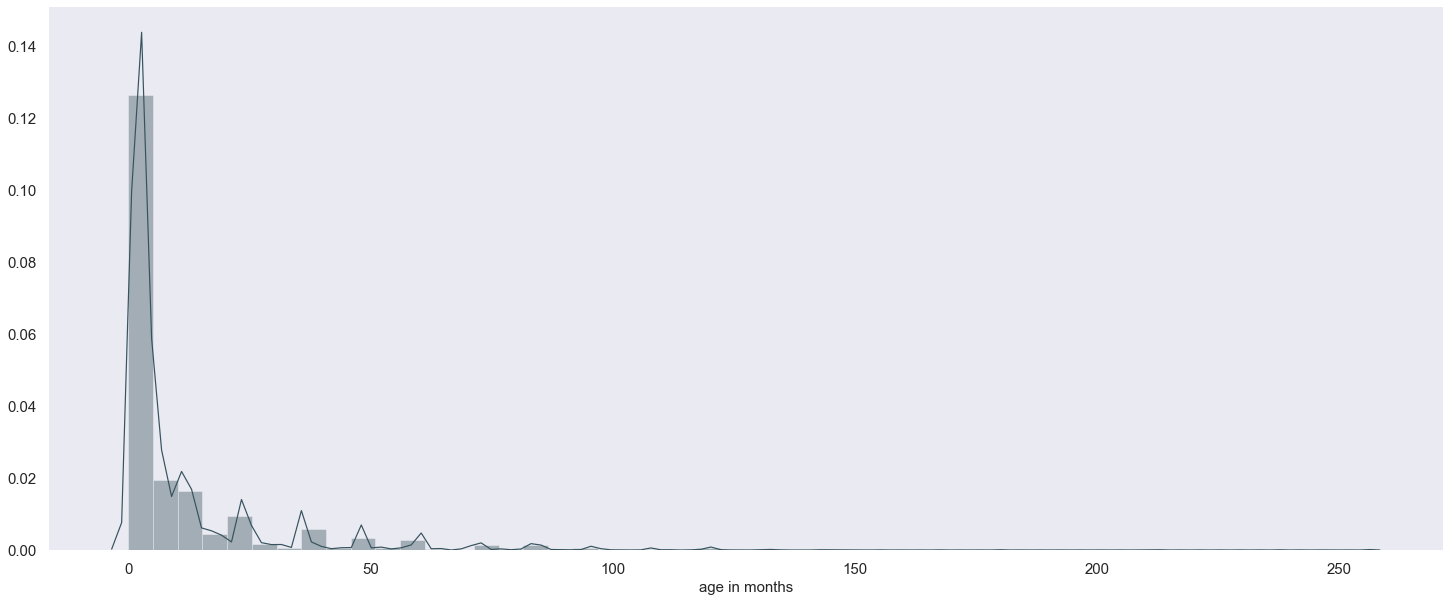

In [10]:
eda.plot_hist(pets["age"], "age in months", (25, 10))

In [11]:
pets.query("age > 24").sort_values("age", ascending = False)[["pet_id", "age", "maturity_size"]].head(10)

pet_id  age  maturity_size
5160   5971c2462  255              2
11172  50682d0f1  255              2
13398  e01f077a7  238              2
11087  e77f9e778  212              1
3998   53923463d  212              2
12855  36d7fc2c5  212              2
8492   1d669183f  180              2
14637  bd006f963  180              2
9267   e5ffc0a9d  168              2
7512   739cd2d34  156              2

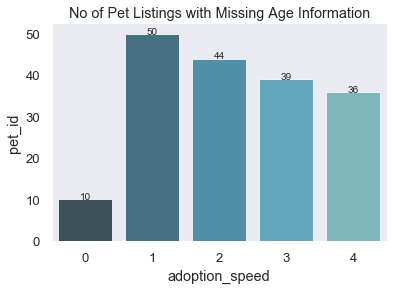

In [12]:
df_plot = pets.query("age == 0").groupby("adoption_speed").count().reset_index()
eda.plot_bar(df_plot, "adoption_speed", "pet_id", "No of Pet Listings with Missing Age Information")

There are 1541 (10%) pets that are more than 2 years old.  Some of them are even more than 20 years old.  I will then convert the age into categorical feature: 0-2 years and more than 2 years old. In addition, age has a very low correlation with adoption speed.

I see no issue with age = 0 at adoption speed of 0-2 as this means the pets were adopted before they reached the age of 1 month.

Adoption speed rates at 3 & 4 mean that the pets were already been listed for more than a month.  I will be removing these listings as this is only {{round(((39+36)/(df.shape[0])),4)*100}}% of the dataset.

### Breed

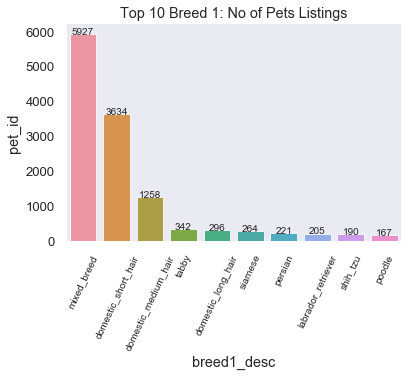

In [13]:
df_plot = pets[["breed1_desc",
                "pet_id"]].groupby("breed1_desc").count().sort_values(
                    "pet_id", ascending=False).iloc[:10, ].reset_index()
eda.plot_bar(df_plot, "breed1_desc", "pet_id",
             "Top 10 Breed 1: No of Pets Listings", rotate = True)

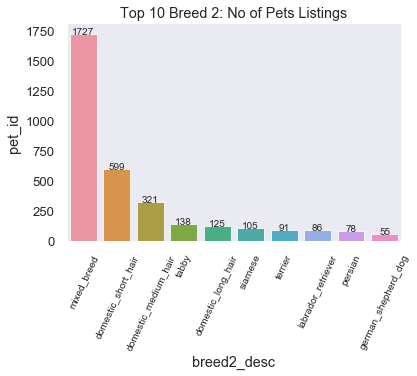

In [14]:
df_plot = pets[["breed2_desc",
                "pet_id"]].groupby("breed2_desc").count().sort_values(
                    "pet_id", ascending=False).iloc[:10, ].reset_index()
eda.plot_bar(df_plot, "breed2_desc", "pet_id",
             "Top 10 Breed 2: No of Pets Listings", rotate = True)

In [30]:
q = """SELECT breed1_desc, fur_length, count(breed1_desc) as listing_count FROM pets WHERE breed1_desc LIKE "%Domestic%" GROUP by breed1_desc, fur_length ORDER by listing_count DESC;"""
table = pysqldf(q)
table

breed1_desc  fur_length  listing_count
0   domestic_short_hair           1           3181
1  domestic_medium_hair           2           1162
2   domestic_short_hair           2            443
3    domestic_long_hair           3            201
4    domestic_long_hair           2             86
5  domestic_medium_hair           1             77
6  domestic_medium_hair           3             19
7   domestic_short_hair           3             10
8    domestic_long_hair           1              9

Mixed breed and domestic are the most common values. 

The domestic breed types are not consistent with the fur length.  Upon checking the website, the breed fields are drop downs while the fur lengths are radio buttons.  The fur length would be more accurately selected as compared to the specific type of "Domestic" breed. I will be changing all these to "Domestic" only and assume that the fur length is correct.

Also I will adding a column that will categorise the listings into Mixed Breed, Pure Breed, Domestic

### Gender

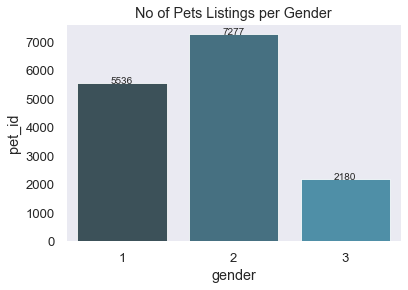

In [16]:
df_plot = pets[["gender","type", "adoption_speed", "pet_id"]].groupby(["gender","type", "adoption_speed"]).count().sort_values("pet_id", ascending=False).reset_index()

eda.plot_bar(df_plot.groupby("gender").sum().reset_index(), "gender", "pet_id",
             "No of Pets Listings per Gender", rotate = False)

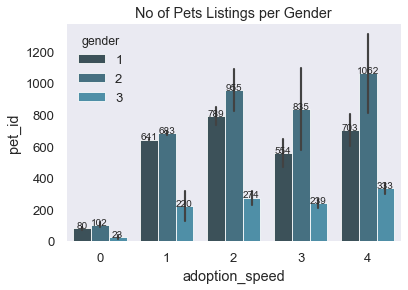

In [17]:
df_plot = pets[["gender","type", "adoption_speed", "pet_id"]].groupby(["gender","type", "adoption_speed"]).count().sort_values("pet_id", ascending=False).reset_index()

eda.plot_bar_hue(df_plot,"adoption_speed", "pet_id", "gender", "No of Pets Listings per Gender", rotate = False)

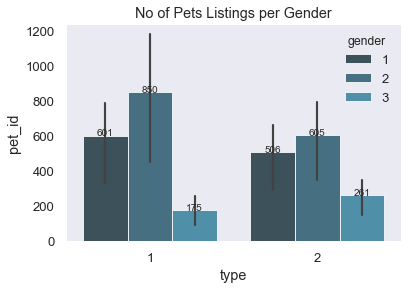

In [18]:
df_plot = pets[["gender","type", "adoption_speed", "pet_id"]].groupby(["gender", "adoption_speed", "type"]).count().sort_values("pet_id", ascending=False).reset_index()

eda.plot_bar_hue(df_plot,"type", "pet_id", "gender", "No of Pets Listings per Gender", rotate = False)

## Preparing the Data for Modelling

In [156]:
pets = pd.read_csv("pets.csv")

### Convert the categorical columns to dummy features

In [157]:
no_age = pets.query("age == 0").query("adoption_speed > 2").index
pets = eda.drop_rows(pets, no_age)

no_images = pets.query("photo_amt == 0").index
pets = eda.drop_rows(pets, no_images)

no_desc = pets[df.description.isna() == True].index
pets = eda.drop_rows(pets, no_desc)

print("Original shape = ", df.shape)
print("New shape = ", pets.shape)

Original shape =  (14993, 30)
New shape =  (14577, 30)


In [158]:
pets = eda.breed_dummies(pets)

pets = eda.color_dummies(pets)

pets = pd.get_dummies(pets, prefix = "state", columns = "state_desc", drop_first = True, dtype = "float64")

col_cat = ["type", "age", "maturity_size", "fur_length", "vaccinated", "dewormed", "sterilized", "health"]
pets.type  = pets.type.map(lambda x: "dog" if x == 1 else "cat")
pets.age = pets.age.map(lambda x: "0-2y" if x <= 24 else ">2y")
pets = pd.get_dummies(pets, columns = col_cat, drop_first = True, dtype = "float64")

pets.fee = pets.fee.astype("float64")

print("New shape = ", pets.shape)
pets.head(2)

New shape =  (14578, 225)


adoption_speed     pet_id         name  breed1           breed1_desc  \
0             2.0  86e1089a3       Nibble   299.0                 tabby   
1             0.0  6296e909a  No Name Yet   265.0  domestic_medium_hair   

   breed2 breed2_desc  gender  color1 color1_desc  color2 color2_desc  color3  \
0     0.0         NaN     1.0     1.0       black     7.0       white     0.0   
1     0.0         NaN     1.0     1.0       black     2.0       brown     0.0   

  color3_desc  quantity    fee    state                        rescuer_id  \
0         NaN       1.0  100.0  41326.0  8480853f516546f6cf33aa88cd76c379   
1         NaN       1.0    0.0  41401.0  3082c7125d8fb66f7dd4bff4192c8b14   

   video_amt  photo_amt                                        description  \
0        0.0        1.0  Nibble is a 3+ month old ball of cuteness. He ...   
1        0.0        2.0  I just found it alone yesterday near my apartm...   

   breed_abyssinian  breed_affenpinscher  breed_airedale_terrier  breed_akita  \
0               0.0                  0.0                     0.0          0.0   
1               0.0                  0.0                     0.0          0.0   

   breed_american_bulldog  breed_american_curl  breed_american_shorthair  \
0                     0.0                  0.0                       0.0   
1                     0.0                  0.0                       0.0   

   breed_american_staffordshire_terrier  breed_american_water_spaniel  \
0                                   0.0                           0.0   
1                                   0.0                           0.0   

   breed_american_wirehair  breed_applehead_siamese  breed_australian_kelpie  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   

   breed_australian_shepherd  breed_australian_terrier  breed_balinese  \
0                        0.0                       0.0             0.0   
1                        0.0                       0.0             0.0   

   breed_basenji  breed_basset_hound  breed_beagle  breed_bearded_collie  \
0            0.0                 0.0           0.0                   0.0   
1            0.0                 0.0           0.0                   0.0   

   breed_bedlington_terrier  breed_belgian_shepherd_dog_sheepdog  \
0                       0.0                                  0.0   
1                       0.0                                  0.0   

   breed_belgian_shepherd_laekenois  breed_belgian_shepherd_malinois  \
0                               0.0                              0.0   
1                               0.0                              0.0   

   breed_bengal  breed_birman  breed_black_labrador_retriever  \
0           0.0           0.0                             0.0   
1           0.0           0.0                             0.0   

   breed_black_mouth_cur  breed_bobtail  breed_bombay  breed_border_collie  \
0                    0.0            0.0           0.0                  0.0   
1                    0.0            0.0           0.0                  0.0   

   breed_boston_terrier  breed_boxer  breed_british_shorthair  \
0                   0.0          0.0                      0.0   
1                   0.0          0.0                      0.0   

   breed_bull_terrier  breed_bullmastiff  breed_burmese  breed_burmilla  \
0                 0.0                0.0            0.0             0.0   
1                 0.0                0.0            0.0             0.0   

   breed_calico  breed_cavalier_king_charles_spaniel  breed_chartreux  \
0           0.0                                  0.0              0.0   
1           0.0                                  0.0              0.0   

   breed_chausie  breed_chihuahua  breed_chinese_crested_dog  \
0            0.0              0.0                        0.0   
1            0.0              0.0                        

In [159]:
col_excl = [
    "name", "state", "rescuer_id", "breed1", "breed1_desc", "breed2",
    "breed2_desc", "gender", "color1", "color1_desc", "color2", "color2_desc",
    "color3", "color3_desc"
]
pets = eda.drop_columns(pets, col_excl)

print("New shape = ", pets.shape)
pets.head(2)

New shape =  (14578, 211)


adoption_speed     pet_id  quantity    fee  video_amt  photo_amt  \
0             2.0  86e1089a3       1.0  100.0        0.0        1.0   
1             0.0  6296e909a       1.0    0.0        0.0        2.0   

                                         description  breed_abyssinian  \
0  Nibble is a 3+ month old ball of cuteness. He ...               0.0   
1  I just found it alone yesterday near my apartm...               0.0   

   breed_affenpinscher  breed_airedale_terrier  breed_akita  \
0                  0.0                     0.0          0.0   
1                  0.0                     0.0          0.0   

   breed_american_bulldog  breed_american_curl  breed_american_shorthair  \
0                     0.0                  0.0                       0.0   
1                     0.0                  0.0                       0.0   

   breed_american_staffordshire_terrier  breed_american_water_spaniel  \
0                                   0.0                           0.0   
1                                   0.0                           0.0   

   breed_american_wirehair  breed_applehead_siamese  breed_australian_kelpie  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   

   breed_australian_shepherd  breed_australian_terrier  breed_balinese  \
0                        0.0                       0.0             0.0   
1                        0.0                       0.0             0.0   

   breed_basenji  breed_basset_hound  breed_beagle  breed_bearded_collie  \
0            0.0                 0.0           0.0                   0.0   
1            0.0                 0.0           0.0                   0.0   

   breed_bedlington_terrier  breed_belgian_shepherd_dog_sheepdog  \
0                       0.0                                  0.0   
1                       0.0                                  0.0   

   breed_belgian_shepherd_laekenois  breed_belgian_shepherd_malinois  \
0                               0.0                              0.0   
1                               0.0                              0.0   

   breed_bengal  breed_birman  breed_black_labrador_retriever  \
0           0.0           0.0                             0.0   
1           0.0           0.0                             0.0   

   breed_black_mouth_cur  breed_bobtail  breed_bombay  breed_border_collie  \
0                    0.0            0.0           0.0                  0.0   
1                    0.0            0.0           0.0                  0.0   

   breed_boston_terrier  breed_boxer  breed_british_shorthair  \
0                   0.0          0.0                      0.0   
1                   0.0          0.0                      0.0   

   breed_bull_terrier  breed_bullmastiff  breed_burmese  breed_burmilla  \
0                 0.0                0.0            0.0             0.0   
1                 0.0                0.0            0.0             0.0   

   breed_calico  breed_cavalier_king_charles_spaniel  breed_chartreux  \
0           0.0                                  0.0              0.0   
1           0.0                                  0.0              0.0   

   breed_chausie  breed_chihuahua  breed_chinese_crested_dog  \
0            0.0              0.0                        0.0   
1            0.0              0.0                        0.0   

   breed_chocolate_labrador_retriever  breed_chow_chow  breed_cocker_spaniel  \
0                                 0.0              0.0                   0.0   
1                                 0.0              0.0                   0.0   

   breed_collie  breed_coonhound  breed_corgi  breed_cymric  breed_dachshund  \
0           0.0              0.0          0.0           0.0              0.0   
1           0.0              0.0          0.0           0.0              0.0   

   breed_dalmatian  breed_dilute_calico  breed_dilute_tortoisesh

In [160]:
pets.isna().sum().sum()

196

In [161]:
pets.dropna(axis = 0,inplace = True)

In [162]:
print("New shape = ", pets.shape)
pets.isna().sum().sum()

New shape =  (14577, 211)


0

In [163]:
#pets.to_csv("pets_modelA.csv", index=False)
pets = pd.read_csv("pets_modelA.csv")
pets.shape

(14577, 211)

### Add image filename to the dataframe

In [164]:
pets = pd.read_csv("pets_modelA.csv")

In [165]:
images_orig_path = "dataset/petfinder-adoption-prediction/train_images"
image_files = []

for r, d, f in os.walk(images_orig_path):  # r=root, d=directories, f = files
    for file in f:
        if ".jpg" in file:
            image_files.append(os.path.join(file))

image_files[:5]

['2d725d001-3.jpg',
 'bf9bd91e1-1.jpg',
 '9cb525274-3.jpg',
 '16ffedcf8-7.jpg',
 'a63364c39-1.jpg']

In [166]:
images = pd.DataFrame(data = image_files, columns = ["file_name"])
images["pet_id"] = images["file_name"].map(lambda x: str(x)[:9])
images = pd.merge(images, pets, on="pet_id", how="left")[["file_name", "pet_id"]]

print("There are ",len(images.drop_duplicates("pet_id")), " pets with images.")
print("There are a total of ",len(images), " pet images.")
images.head()

There are  14652  pets with images.
There are a total of  58311  pet images.


file_name     pet_id
0  2d725d001-3.jpg  2d725d001
1  bf9bd91e1-1.jpg  bf9bd91e1
2  9cb525274-3.jpg  9cb525274
3  16ffedcf8-7.jpg  16ffedcf8
4  a63364c39-1.jpg  a63364c39

In [167]:
unique_images = images.drop_duplicates("pet_id")
unique_images.shape

(14652, 2)

In [168]:
pets = pd.merge(pets, unique_images, on="pet_id", how="left")
pets.head(2)

adoption_speed     pet_id  quantity    fee  video_amt  photo_amt  \
0             2.0  86e1089a3       1.0  100.0        0.0        1.0   
1             0.0  6296e909a       1.0    0.0        0.0        2.0   

                                         description  breed_abyssinian  \
0  Nibble is a 3+ month old ball of cuteness. He ...               0.0   
1  I just found it alone yesterday near my apartm...               0.0   

   breed_affenpinscher  breed_airedale_terrier  breed_akita  \
0                  0.0                     0.0          0.0   
1                  0.0                     0.0          0.0   

   breed_american_bulldog  breed_american_curl  breed_american_shorthair  \
0                     0.0                  0.0                       0.0   
1                     0.0                  0.0                       0.0   

   breed_american_staffordshire_terrier  breed_american_water_spaniel  \
0                                   0.0                           0.0   
1                                   0.0                           0.0   

   breed_american_wirehair  breed_applehead_siamese  breed_australian_kelpie  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   

   breed_australian_shepherd  breed_australian_terrier  breed_balinese  \
0                        0.0                       0.0             0.0   
1                        0.0                       0.0             0.0   

   breed_basenji  breed_basset_hound  breed_beagle  breed_bearded_collie  \
0            0.0                 0.0           0.0                   0.0   
1            0.0                 0.0           0.0                   0.0   

   breed_bedlington_terrier  breed_belgian_shepherd_dog_sheepdog  \
0                       0.0                                  0.0   
1                       0.0                                  0.0   

   breed_belgian_shepherd_laekenois  breed_belgian_shepherd_malinois  \
0                               0.0                              0.0   
1                               0.0                              0.0   

   breed_bengal  breed_birman  breed_black_labrador_retriever  \
0           0.0           0.0                             0.0   
1           0.0           0.0                             0.0   

   breed_black_mouth_cur  breed_bobtail  breed_bombay  breed_border_collie  \
0                    0.0            0.0           0.0                  0.0   
1                    0.0            0.0           0.0                  0.0   

   breed_boston_terrier  breed_boxer  breed_british_shorthair  \
0                   0.0          0.0                      0.0   
1                   0.0          0.0                      0.0   

   breed_bull_terrier  breed_bullmastiff  breed_burmese  breed_burmilla  \
0                 0.0                0.0            0.0             0.0   
1                 0.0                0.0            0.0             0.0   

   breed_calico  breed_cavalier_king_charles_spaniel  breed_chartreux  \
0           0.0                                  0.0              0.0   
1           0.0                                  0.0              0.0   

   breed_chausie  breed_chihuahua  breed_chinese_crested_dog  \
0            0.0              0.0                        0.0   
1            0.0              0.0                        0.0   

   breed_chocolate_labrador_retriever  breed_chow_chow  breed_cocker_spaniel  \
0                                 0.0              0.0                   0.0   
1                                 0.0              0.0                   0.0   

   breed_collie  breed_coonhound  breed_corgi  breed_cymric  breed_dachshund  \
0           0.0              0.0          0.0           0.0              0.0   
1           0.0              0.0          0.0           0.0              0.0   

   breed_dalmatian  breed_dilute_calico  breed_dilute_tortoisesh

In [169]:
# pets.to_csv("pets_modelB.csv", index=False)
pets = pd.read_csv("pets_modelB.csv")
pets.shape

(14578, 212)

# Multi-class Problem

In [170]:
pets = pd.read_csv("pets_modelA.csv", index_col="pet_id")
pets = eda.drop_columns(pets, "description")
display(pets.shape)
pets.head(2)

(14577, 209)

adoption_speed  quantity    fee  video_amt  photo_amt  \
pet_id                                                             
86e1089a3             2.0       1.0  100.0        0.0        1.0   
6296e909a             0.0       1.0    0.0        0.0        2.0   

           breed_abyssinian  breed_affenpinscher  breed_airedale_terrier  \
pet_id                                                                     
86e1089a3               0.0                  0.0                     0.0   
6296e909a               0.0                  0.0                     0.0   

           breed_akita  breed_american_bulldog  breed_american_curl  \
pet_id                                                                
86e1089a3          0.0                     0.0                  0.0   
6296e909a          0.0                     0.0                  0.0   

           breed_american_shorthair  breed_american_staffordshire_terrier  \
pet_id                                                                      
86e1089a3                       0.0                                   0.0   
6296e909a                       0.0                                   0.0   

           breed_american_water_spaniel  breed_american_wirehair  \
pet_id                                                             
86e1089a3                           0.0                      0.0   
6296e909a                           0.0                      0.0   

           breed_applehead_siamese  breed_australian_kelpie  \
pet_id                                                        
86e1089a3                      0.0                      0.0   
6296e909a                      0.0                      0.0   

           breed_australian_shepherd  breed_australian_terrier  \
pet_id                                                           
86e1089a3                        0.0                       0.0   
6296e909a                        0.0                       0.0   

           breed_balinese  breed_basenji  breed_basset_hound  breed_beagle  \
pet_id                                                                       
86e1089a3             0.0            0.0                 0.0           0.0   
6296e909a             0.0            0.0                 0.0           0.0   

           breed_bearded_collie  breed_bedlington_terrier  \
pet_id                                                      
86e1089a3                   0.0                       0.0   
6296e909a                   0.0                       0.0   

           breed_belgian_shepherd_dog_sheepdog  \
pet_id                                           
86e1089a3                                  0.0   
6296e909a                                  0.0   

           breed_belgian_shepherd_laekenois  breed_belgian_shepherd_malinois  \
pet_id                                                                         
86e1089a3                               0.0                              0.0   
6296e909a                               0.0                              0.0   

           breed_bengal  breed_birman  breed_black_labrador_retriever  \
pet_id                                                                  
86e1089a3           0.0           0.0                             0.0   
6296e909a           0.0           0.0                             0.0   

           breed_black_mouth_cur  breed_bobtail  breed_bombay  \
pet_id                                                          
86e1089a3                    0.0            0.0           0.0   
6296e909a                    0.0            0.0           0.0   

           breed_border_collie  breed_boston_terrier  breed_boxer  \
pet_id                                                              
86e1089a3                  0.0                   0.0          0.0   
6296e909a                  0.0                   0.0          0.0   

           breed_british_shorthair  breed_bull_terrier  breed_bullmastiff  \
pet_id                                                      

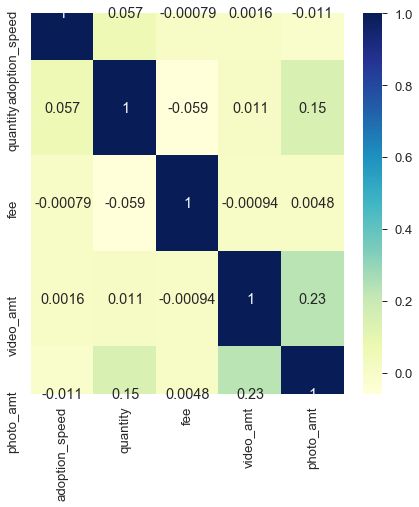

In [171]:
plt.figure(figsize=(7, 7))
sns.heatmap(data = pets.iloc[:,0:5].corr(), annot=True, cmap="YlGnBu");

In [172]:
y = pets[["adoption_speed"]]
X = eda.drop_columns(pets, "adoption_speed")

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [189]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [195]:
logreg = LogisticRegression(class_weight="balanced",
                            multi_class="ovr")#,
                            #solver="lbfgs")

In [200]:
crossvalidation = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
baseline = np.mean(cross_val_score(logreg, X_train_scaled, y_train, scoring="accuracy", cv=crossvalidation))

In [201]:
baseline

0.33708374404095576

In [190]:
logreg.fit(X_train_scaled, y_train)

y_train_pred= logreg.predict(X_train_scaled)
y_test_pred = logreg.predict(X_test_scaled)
probas = logreg.predict_proba(X_test_scaled)

print(classification_report(y_train, y_train_pred))

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.10      0.31      0.15       287
         1.0       0.33      0.38      0.36      2287
         2.0       0.35      0.27      0.30      3024
         3.0       0.35      0.27      0.30      2392
         4.0       0.47      0.54      0.50      2942

    accuracy                           0.36     10932
   macro avg       0.32      0.35      0.32     10932
weighted avg       0.37      0.36      0.36     10932

              precision    recall  f1-score   support

         0.0       0.08      0.24      0.12        99
         1.0       0.31      0.36      0.33       767
         2.0       0.31      0.24      0.27       972
         3.0       0.32      0.23      0.27       795
         4.0       0.45      0.50      0.47      1012

    accuracy                           0.33      3645
   macro avg       0.29      0.31      0.29      3645
weighted avg       0.34      0.33      0.33      3645



# Image Classification

In [ ]:
# images_orig_path = "dataset/petfinder-adoption-prediction/train_images"
# image_files = []

# for r, d, f in os.walk(images_orig_path):  # r=root, d=directories, f = files
#     for file in f:
#         if ".jpg" in file:
#             image_files.append(os.path.join(file))

image_files[:5]

In [ ]:
# images = pd.DataFrame(data = image_files, columns = ["file_name"])
# images["pet_id"] = images["file_name"].map(lambda x: str(x)[:9])
# images = pd.merge(images, pets, on="pet_id", how="left")[["file_name", "pet_id", "type"]]

# print("There are ",len(images.drop_duplicates("pet_id")), " pets with images.")
# print("There are a total of ",len(images), " pet images.")
# images.head()

In [ ]:
# images_dog = list(images.query("type == 1").file_name)
# images_cat = list(images.query("type == 2").file_name)

# dog_folder = "dataset/images/dog/"
# cat_folder = "dataset/images/cat/"

# im.copy_images(images_dog, images_orig_path, dog_folder)
# im.copy_images(images_cat, images_orig_path, cat_folder)

In [ ]:
# images_dog = list(images.drop_duplicates("pet_id").query("type == 1").file_name)
# images_cat = list(images.drop_duplicates("pet_id").query("type == 2").file_name)

# dog_folder = "dataset/images_unique/dog/"
# cat_folder = "dataset/images_unique/cat/"

# im.copy_images(images_dog, images_orig_path, dog_folder)
# im.copy_images(images_cat, images_orig_path, cat_folder)

# Text Classification

In [ ]:
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# pets_desc = pets[["pet_id","adoption_speed", "description"]]
# pets_desc

In [ ]:
# stopwords_list = stopwords.words("english") + list(string.punctuation)